# 1. Introduction

In part 2 of this series on principal component analysis (factor analysis) of mixed data, we will go over several fundamental metrics for understanding the relationships between variables and principal components.

For part 1, the Jupyter notebook can be found under the "Files" tab.

# 2. Import and pre-process data

In [1]:
df <- read.csv('https://github.com/nd823/data-cleaning/raw/master/telco_cleaned_Jun13.csv')

df <- within(df, rm('Calculated_TotalCharges'))

# 3. Investigating the relationships between variables and principal components

## 3.1 Factor loading and squared loading

The **factor loading** of a variable describes the correlation, *i.e.* information shared, between it and a given principal component (PC). 

By squaring the factor loading for a variable, we also get its **squared loading** (also called **squared cosine** or **cos2**). This provides a measure of the **proportion** of variance in a variable that is captured by a PC. So, for each variable the sum of its squared loading across all PCs equals to 1. 

One way to depict this relationship is using **correlation circles**, which plot variables using their loadings for PC1 and PC2 (or any other two PCs chosen) as coordinates. It is very useful in illustrating some key concepts for interpreting PCA results. 

Note that **only quantitative variables** can be depicted in correlation circles. Here is an example using the Telco dataset, in which `MonthlyCharges` and `Tenure` are the two quantitative variables (after removing the `TotalCharges` variable that is essentially a product of the two):

Warning message in splitmix(df):
“Columns of class integer are considered as quantitative”

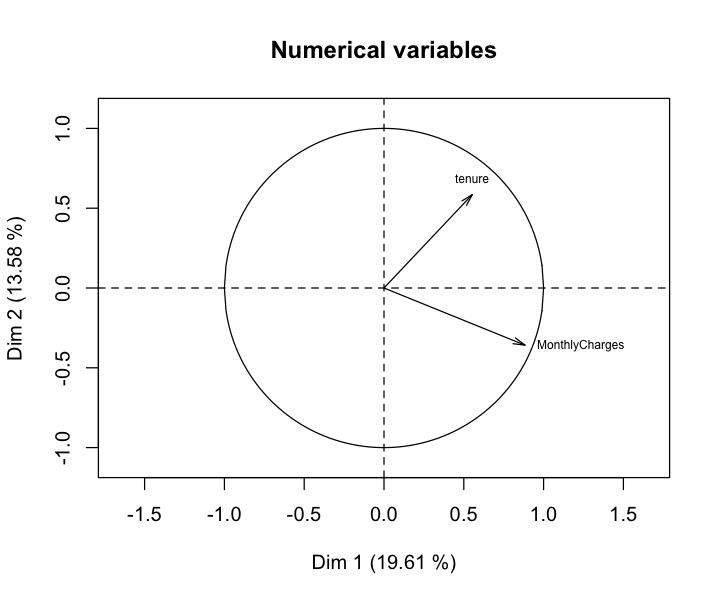

In [38]:
library(PCAmixdata)

## Split quantitative and qualitative variables
split <- splitmix(df)

## PCA
res.pcamix <- PCAmix(X.quanti=split$X.quanti,  
                     X.quali=split$X.quali, 
                     rename.level=TRUE, 
                     graph=FALSE, 
                     ndim=25)

## Plotting
options(repr.plot.width=6, repr.plot.height=5)

plot(res.pcamix,
     choice="cor", 
     main="Numerical variables", 
     cex=0.6)

To interpret this figure, recall that the sum of squared loadings for a given variable across all PCs equals 1. So if a given variable can be perfectly represented by only the two PCs plotted, then:

$$(factor\ loading_{PC1})^2 + (factor\ loading_{PC2})^2  = 1$$

When plotted using factor loading on each PC as coordinates in a Cartesian grid, this is the same as $$x^2 + y^2  = 1$$

The circle in the plot has a radius of 1, meaning that the projection endpoint for any such variable would be positioned **on** the circle. In the figure above, we see that PC1 and PC2 together do a pretty good job of capturing information contained in the `MonthlyCharges` variable, as its endpoint is very close to the circle. Conversely, if more PCs are needed to capture the information contained in a variable, then the length of it projection would be less than 1 and the endpoint would be positioned **inside** the circle. Projection for the `Tenure` variable lies closer to the origin than that of `MonthlyCharges`, indicating that more than PC1 and PC2 are needed to completely represent the information it contains. **Therefore, the closer a variable is to the circle, then more important it is to interpreting the PCs involved.**

To visualize qualitative and quantitative variables together in the same principal subspace, the `PCAmixdata` package offers an implementation called "squared loading plot". This has the added benefit of allowing me to include the `Churn` variable as a supplementary variable, thereby seeing its relationship with other variables without including it in the original analysis. This is useful as most downstream analyses would try to predict `Churn`.

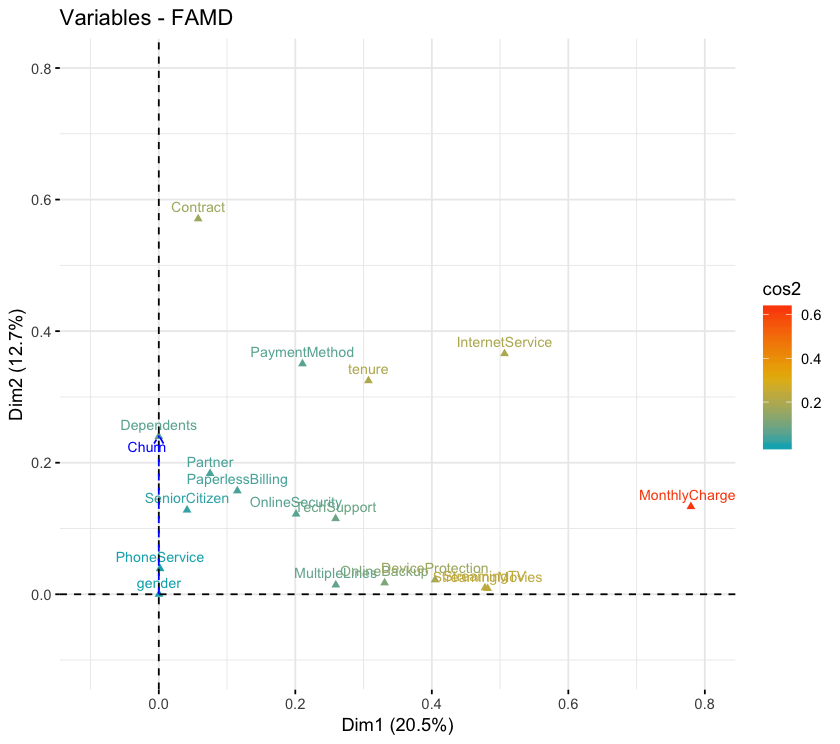

In [51]:
## Import libraries
library(FactoMineR)
library(factoextra)

## PCA
res.famd <- FAMD(df, 
                 sup.var = 19, 
                 graph = FALSE, 
                 ncp=25)

## Visualization
options(repr.plot.width=7, repr.plot.height=6.2)

p1 <- fviz_famd_var(res.famd, 'var', axes = c(1, 2),
                     labelsize = 3,
                     col.var = 'cos2',       ## I can colour the points by their squared loading, making comparing variables easier
                     gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
                     repl=TRUE) +
                     xlim(-0.1, 0.8) + ylim (-0.1, 0.8)

fviz_add(p1, 
               res.famd$var$coord.sup,
               geom = c("arrow", "text"),
               labelsize = 3,
               col.var = 'cos2',
               color = "blue", 
               repel=TRUE)

As a sidenote, unlike correlation circles, this plot depicts only positive values on the x- and y-axis. According to the authors of the package (Chavent et al., 2014), the coordinates are to be interpreted as measuring "the links (signless) between variables and principal components". Does this mean that they are the absolute values of factor loadings for PC1 and PC2? 

Nevertheless, we see several interesting things in the figure above:
- Consistent with what we saw in the correlation circle, `MonthlyCharges` is more closely correlated with PC1 than PC2, and `Tenure` is described by some combination of PC1 and PC2
- Being furthest from the origin, the variables `Contract`, `InternetService` and `MonthlyCharges` have higher squared loading values and so are more important in explaining the variance captured by PC1 and PC2 than variables clustered near the origin, such as `Gender`, `PhoneService`, and `SeniorCitizen` 
    - This can also be seen in the colouring gradient from green to red
- The variable of interest, `Churn`, overlaps with the y-axis, indicating that PC2 **alone** perfectly captures all the variation contained in this variable

To further facilitate interpretation of the relationships between variables and PCs, **additional** rotation can be applied to PCs to result in high factor loadings for a few variables and low factor loadings for the rest. In other words, a small number of variables will become highly correlated with each PC. The most common form of rotation is varimax rotation, a generalized form of which is implemented in the `PCAmixdata` package for mixed data.

Here we will visualize the result of varimax rotation on relationships between variables and the first two PCs.

Warning message in graphics::arrows(0, 0, res.pca$sqload[j, dim1], res.pca$sqload[j, :
“zero-length arrow is of indeterminate angle and so skipped”Warning message in graphics::arrows(0, 0, res.pca$sqload[j, dim1], res.pca$sqload[j, :
“zero-length arrow is of indeterminate angle and so skipped”

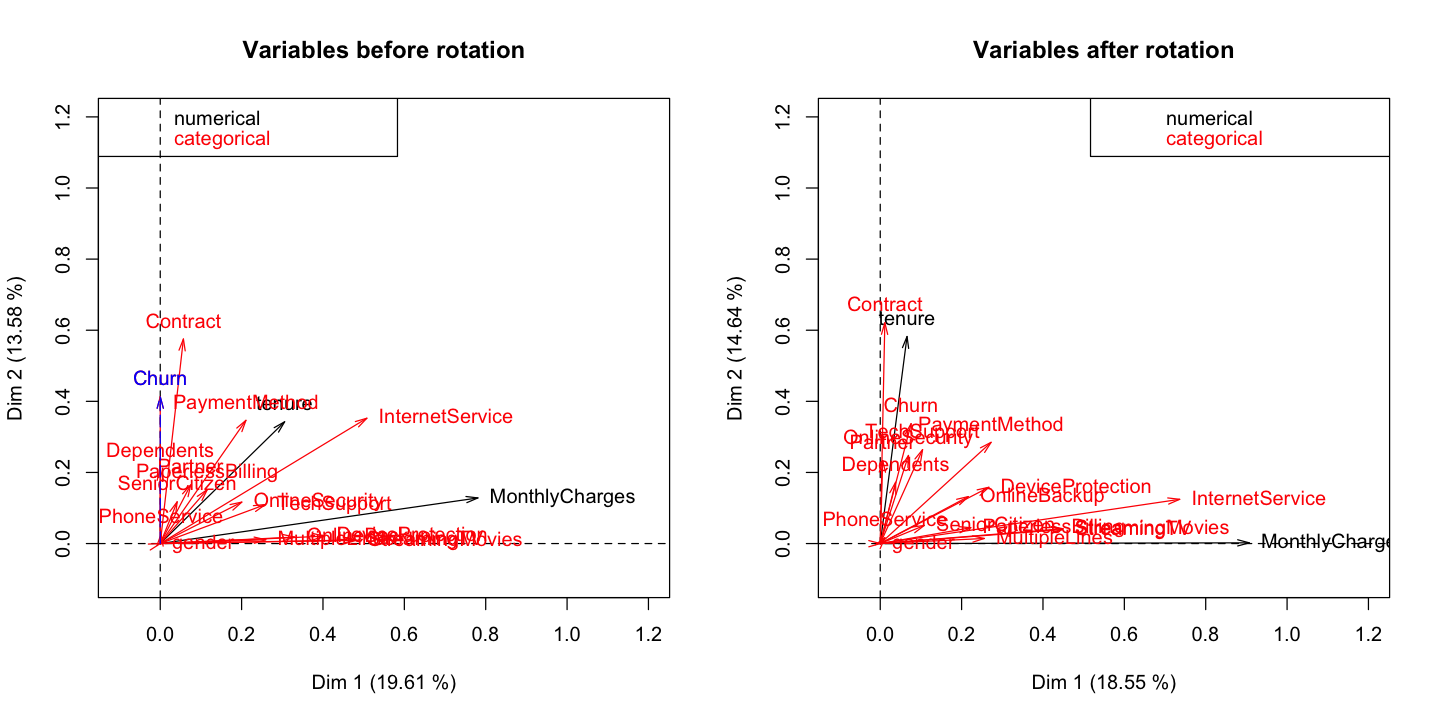

In [57]:
## Add "Churn" as a supplementary varible
res.sup <- supvar(res.pcamix,  
                  X.quanti.sup = NULL, 
                  X.quali.sup = df[19], 
                  rename.level=TRUE)

## Apply varimax rotation to the first two PCs
res.pcarot <- PCArot(res.sup,
                     dim=2,
                     graph=FALSE)

## Visualize factor loadings before and after rotation
options(repr.plot.width=12, repr.plot.height=6)

par(mfrow=c(1, 2))

plot(res.sup, 
     choice="sqload", 
     coloring.var=TRUE, 
     axes=c(1, 2),
     leg=TRUE, posleg="topleft", main="Variables before rotation",
     xlim=c(0,1), ylim=c(0,1))

plot(res.pcarot, 
     choice="sqload", 
     coloring.var=TRUE,
     axes=c(1, 2),
     leg=TRUE, posleg="topright", main="Variables after rotation", 
     xlim=c(0,1), ylim=c(0,1))

We see higher factor loading of `MonthlyCharges` and `InternetService` for the rotated PC1, and `Tenure` and `Contract` for the rotated PC2 (as their projections are more closely aligned either axis). This indicates these four variables are the most important in accounting for overall variation in the entire dataset.  

Interestingly, correlation between PC2 and `Churn` has decreased after rotation, with increased factor loading for PC1.  

## 3.2 Contribution

Whereas factor loading and squared loading measure how well a given PC "describes" variation capture in a variable, **contribution** describes the converse, namely how much a variable accounts for the total variation captured by a given PC. It is important to compare the squared loading and contribution for each variable to critically assess its relationship with a given PC, as a variable that is important for a PC may not be well represented by the same PC, which warrants very different interpretation as compared to the converse. 


Top contributing variables to the first few PCs can provide insights into which variables underlie variations in the dataset, and may help with feature selection for downstream analyses. The `FactorMineR` package can be used to visualize the top contributing variable to each PC. The red dashed line indicates the expected average contribution (100% contribution divided the total number of variables avaiable in the dataset). So variables meeting the cut-off would be considered as important in contributing to the PC. 

Here we plot out the top 10 contributing variables to each of the first two PCs separately, and then look at them together. Note, as varimax rotation for FAMD results is not possible in the `FactoMineR` package, the PCs visualized here are unrotated.

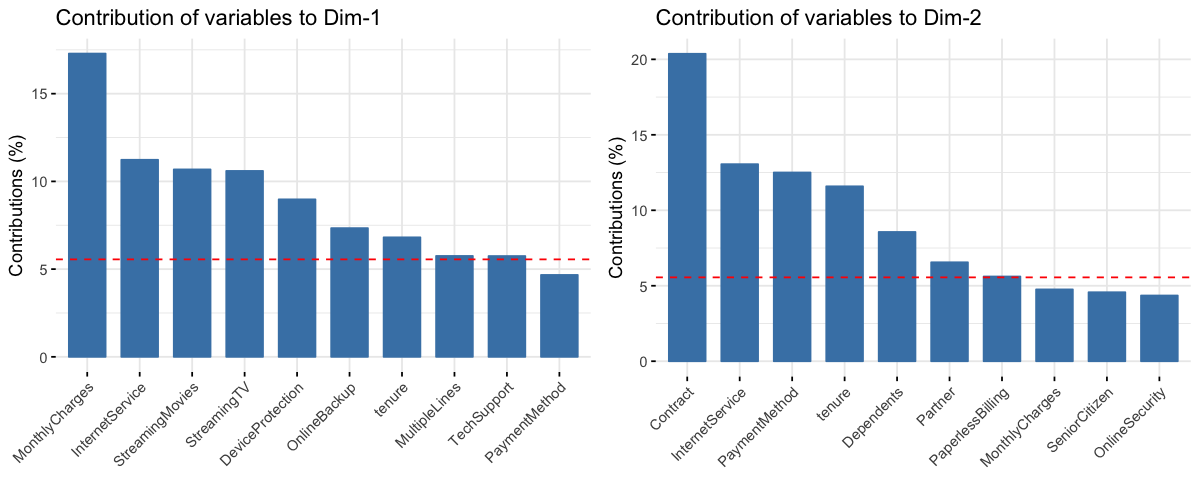

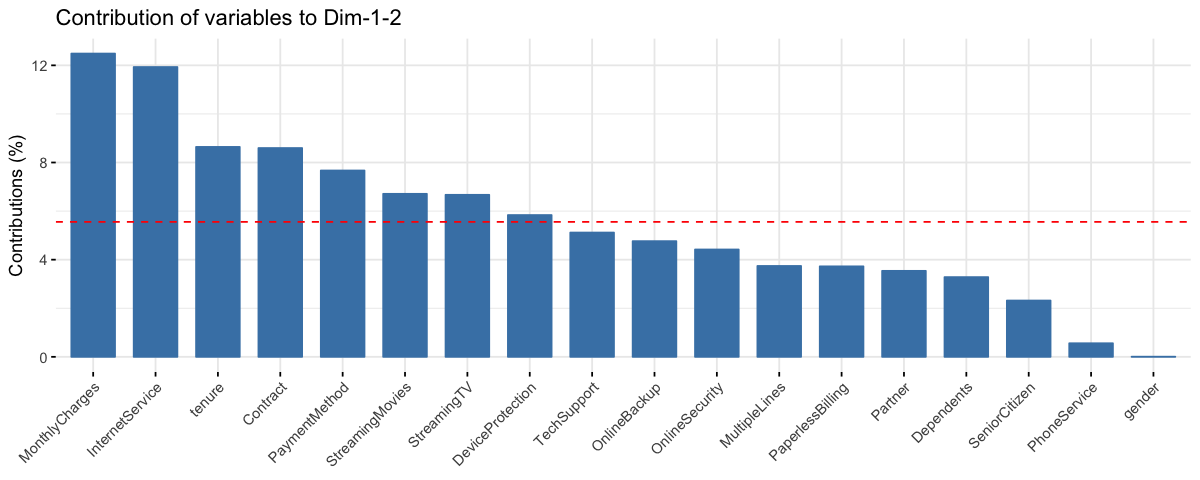

In [68]:
options(repr.plot.width=10, repr.plot.height=4)

a <- fviz_contrib(res.famd, choice = "var", axes = 1, top = 10)

b <- fviz_contrib(res.famd, choice = "var", axes = 2, top = 10)

grid.arrange(a, b, nrow=1)

fviz_contrib(res.famd, choice = "var", axes = 1:2, top = 20)

These figures suggest that the variables `MonthlyCharges`, `InternetService` and `Tenure` play a significant part in accounting for the overall variation in this dataset, and so may warrant further investigations.

Whew, that was a pretty deep dive into the fundamentals of PCA and FAMD!

In the next part of this series, we will delve deeper into examinng relationships between variables. Til then! :)